# Training EfficientNet B0 with Focal Loss on The Model

## Library Imports

In [27]:
from autogluon.multimodal import MultiModalPredictor
from ray import tune
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import os

torch.set_float32_matmul_precision("medium")

In [2]:
NUM_TRIALS = 100

## Data Imports

In [3]:
train_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/train_df.csv")
test_df = pd.read_csv("E:/Current_Workdir/palm-fruit-classification/data/clean/test_df.csv")

## Finetuning EfficientNet B2

Calculate class proportions for Focal Loss $\alpha$  
see [this](https://amaarora.github.io/posts/2020-06-29-FocalLoss.html) for details.

In [4]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights_list = class_weights.tolist()
class_weights_list

[2.1965174129353233,
 1.1964769647696476,
 0.44327309236947793,
 5.660256410256411,
 0.5145687645687645,
 3.003401360544218]

Set Training Folder Name

In [5]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path = "../model/" + f"train_EfficientNetB2_100_trials_{timestamp_str}"

In [6]:
model_path

'../model/train_EfficientNetB2_100_trials_2024-12-06_11-02-58'

In [7]:
os.makedirs(model_path, exist_ok=True)

Defining Hyperparameters

In [8]:
hyperparameters = {
    "optimization.learning_rate": tune.loguniform(0.00001, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.choice([8, 16, 32, 64, 128, 256]),
    #"env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(1, 3),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": "efficientnet_b2",
    "optimization.optim_type": "adamw",
    "optimization.top_k_average_method": "best"
}

In [9]:
predictor = MultiModalPredictor(label="label_text", path=model_path, problem_type='multiclass', eval_metric="f1_macro")

In [10]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    "num_trials": NUM_TRIALS
}

In [11]:
predictor.fit(
        train_data=train_df,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        # time_limit = 3600
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.10
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          32
Pytorch Version:    2.4.1
CUDA Version:       12.4
Memory Avail:       111.73 GB / 127.91 GB (87.3%)
Disk Space Avail:   1455.24 GB / 1863.00 GB (78.1%)


Trial name,should_checkpoint,val_f1_macro
002b9342,True,0.993561
07191b4e,True,0.304241
0952a341,True,0.170453
0bc99024,True,0.393623
0c14e1b0,True,0.34568
0da373bc,True,0.270523
0e822910,True,0.170453
0fc497c7,True,0.988382
15d831f5,True,0.169894
1b417503,True,0.18049


(raylet) The log monitor on node DESKTOP-JR4K5FK failed with the following error:
Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\shutil.py", line 853, in move
    os.rename(src, real_dst)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\comp4\\AppData\\Local\\Temp\\ray\\session_2024-12-06_11-03-01_658853_5172\\logs\\worker-549b30c2c5e8df1fb7cb6ef5190d879b45495accfd0b551bddf085f3-01000000-17932.err' -> 'C:\\Users\\comp4\\AppData\\Local\\Temp\\ray\\session_2024-12-06_11-03-01_658853_5172\\logs\\old\\worker-549b30c2c5e8df1fb7cb6ef5190d879b45495accfd0b551bddf085f3-01000000-17932.err'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\ray\_private\log_monitor.py", line 566, in <module>
    log_monitor.run()
  File "e:\Programs\miniforge3\envs\

Removing non-optimal trials and only keep the best one.
e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\autogluon\multimodal\utils\checkpoint.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues

## Continue Training After Error

In [12]:
# predictor = MultiModalPredictor.load(model_path)

In [13]:
# predictor.fit(
#         train_data=train_df,
#         hyperparameters=hyperparameters,
#         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
#         # time_limit = 3600
# )

In [14]:
# predictor = MultiModalPredictor.load("e:/Current_Workdir/palm-fruit-classification/autogluon_ver/model/train_EfficientNetB2_2024-12-05_15-54-35")

## Evaluate on Test Dataset

In [15]:
scores = predictor.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:01<00:00, 10.92it/s]


{'f1_macro': 0.9039699057343967,
 'f1_micro': 0.9023746701846965,
 'accuracy': 0.9023746701846965,
 'recall_macro': 0.8977120169149155,
 'precision_macro': 0.9122071051531524}

In [16]:
preds = predictor.predict(test_df)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 15.27it/s]


In [17]:
true_labels = test_df['label_text']

# Classification Report

In [28]:
cr = classification_report(true_labels, preds)

In [30]:
print(cr)

              precision    recall  f1-score   support

 empty_bunch       0.95      0.91      0.93        23
    overripe       0.85      0.93      0.88        54
        ripe       0.91      0.89      0.90       154
      rotten       0.86      0.75      0.80         8
   underripe       0.90      0.91      0.90       130
      unripe       1.00      1.00      1.00        10

    accuracy                           0.90       379
   macro avg       0.91      0.90      0.90       379
weighted avg       0.90      0.90      0.90       379



In [18]:
cm = confusion_matrix(true_labels, preds)

In [19]:
cm

array([[ 21,   1,   0,   1,   0,   0],
       [  1,  50,   1,   0,   2,   0],
       [  0,   6, 137,   0,  11,   0],
       [  0,   2,   0,   6,   0,   0],
       [  0,   0,  12,   0, 118,   0],
       [  0,   0,   0,   0,   0,  10]], dtype=int64)

Accuracy per Class

In [26]:
cm.diagonal()/cm.sum(axis=1)

array([0.91304348, 0.92592593, 0.88961039, 0.75      , 0.90769231,
       1.        ])

Detailed Classification Report

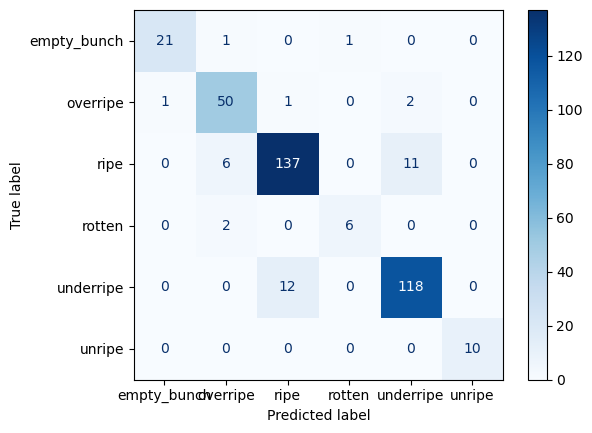

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Inference Example

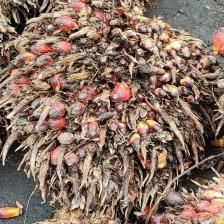

In [21]:
image_path = test_df.iloc[0]['image']
pil_img = Image.open(image_path)  # Use .open() instead of calling Image
display(pil_img)

In [22]:
predictions = predictor.predict({'image': [image_path]})
predictions

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


array(['overripe'], dtype=object)

In [23]:
proba = predictor.predict_proba({'image': [image_path]})
print(proba)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s]
[[3.4552076e-04 9.9829370e-01 1.2130731e-03 6.1208465e-07 1.4657085e-04
  6.1448026e-07]]


In [24]:
feature = predictor.extract_embedding({'image': [image_path]})
print(feature[0].shape)

e:\Programs\miniforge3\envs\autogluon_stable_112\Lib\site-packages\lightning\pytorch\plugins\precision\amp.py:52: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 27.78it/s]
(1408,)


## Save Raw TIMM Format

In [25]:
predictor.dump_model(model_path + "/timm")

Model timm_image weights saved to ../model/train_EfficientNetB2_100_trials_2024-12-06_11-02-58/timm\timm_image/pytorch_model.bin.
Timm config saved to ../model/train_EfficientNetB2_100_trials_2024-12-06_11-02-58/timm\timm_image/config.json.


'../model/train_EfficientNetB2_100_trials_2024-12-06_11-02-58/timm'